# Подготовка модели распознавания рукописных букв и цифр

## Установка и импорт библиотек

In [23]:
"""
!pip install numpy
!pip install matplotlib
!pip install torch torchvision torchinfo
"""

'\n!pip install numpy\n!pip install matplotlib\n!pip install torch torchvision torchinfo\n'

In [24]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize
from torchinfo import summary
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import warnings

from torchvision.datasets import EMNIST
import os
import pickle

In [25]:
warnings.filterwarnings("ignore")

## Знакомство с данными

In [26]:
dataset = EMNIST('data/', 'balanced', download=False)

In [27]:
with open('data/EMNIST/raw/emnist-balanced-mapping.txt', 'r') as file:
    mapping = {}
    for row in file:
        label, code = row.split(' ')
        mapping[int(label)] = chr(int(code))

mapping

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
 10: 'A',
 11: 'B',
 12: 'C',
 13: 'D',
 14: 'E',
 15: 'F',
 16: 'G',
 17: 'H',
 18: 'I',
 19: 'J',
 20: 'K',
 21: 'L',
 22: 'M',
 23: 'N',
 24: 'O',
 25: 'P',
 26: 'Q',
 27: 'R',
 28: 'S',
 29: 'T',
 30: 'U',
 31: 'V',
 32: 'W',
 33: 'X',
 34: 'Y',
 35: 'Z',
 36: 'a',
 37: 'b',
 38: 'd',
 39: 'e',
 40: 'f',
 41: 'g',
 42: 'h',
 43: 'n',
 44: 'q',
 45: 'r',
 46: 't'}

In [28]:
with open(os.path.join('myapp', 'mapping.pkl'), 'wb') as file:
    pickle.dump(mapping, file) 

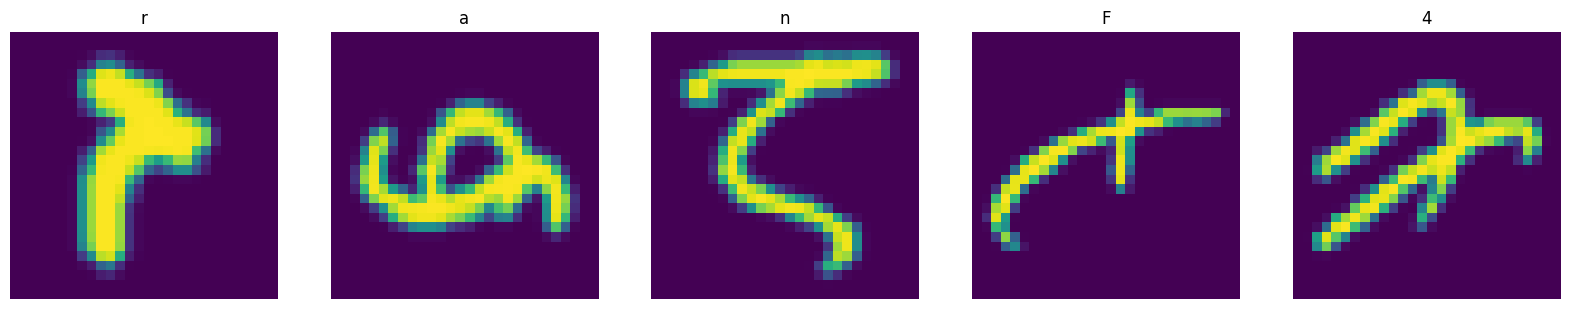

In [29]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    axs[i].imshow(dataset[i][0])
    axs[i].set_title(mapping[dataset[i][1]])
    axs[i].axis('off')
plt.show()

In [30]:
# Найдем среднее и стандартное отклонение тренировочной подвыборки

# Загрузка датасета с нужной трансформацией
transform = ToTensor()
dataset = EMNIST(root='./data', 
                 split='balanced', 
                 train=True, 
                 download=True, 
                 transform=transform)

# Вычисление суммы и суммы квадратов
mean = 0.0
std = 0.0
num_samples = 0

for image, _ in dataset:
    num_samples += 1
    mean += image.mean()
    std += image.std()

# Деление на общее количество изображений для получения среднего и стандартного отклонения
mean /= num_samples
std /= num_samples

print(f'Среднее значение: {mean:.2f}')
print(f'Стандартное отклонение: {std:.2f}')

Среднее значение: 0.18
Стандартное отклонение: 0.33


## Подготовка данных

In [31]:
# Загрузим тестовую и тренировочную выборку использовав для нормализации среднее и стандартное отклонение
transform = Compose([
    ToTensor(),
    Normalize([mean], [std]) #[0.5], [0.5]
])

train_dataset = EMNIST('data/', 'balanced', download=False, train=True, transform=transform)
val_dataset = EMNIST('data/', 'balanced', download=False, train=False, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000)

In [32]:
n_classes = len(mapping.keys())
print(f'Количество классов: {n_classes}')

Количество классов: 47


In [33]:
len(train_loader.dataset), len(val_loader.dataset)

(112800, 18800)

## Сборка модели

In [34]:
class CNN(nn.Module):
    
    def __init__(self, n_classes):
        super().__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2)) # попробовать поменять на AvgPool2d 

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), nn.Flatten())
        self.drop = nn.Dropout()
        self.fc1 = nn.Linear(in_features=64*7*7, out_features=1024)        
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=n_classes)


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        #out = out.reshape(out.size(0), -1)
        out = self.drop(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [35]:
net = CNN(n_classes)
summary(net, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 47]                   --
├─Sequential: 1-1                        [1, 32, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           832
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
├─Sequential: 1-2                        [1, 3136]                 --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           51,264
│    └─BatchNorm2d: 2-5                  [1, 64, 14, 14]           128
│    └─ReLU: 2-6                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-7                    [1, 64, 7, 7]             --
│    └─Flatten: 2-8                      [1, 3136]                 --
├─Dropout: 1-3                           [1, 3136]                 --
├─Linear: 1-4                            [1, 1024]                 3,212,288
├─

In [330]:
# train ver 1
def train_v1(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre):
    model.train()
    for epoch in range(n_epoch):
        loss_sum = 0
        print(f'Epoch: {epoch}')
        for step, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data).squeeze(1)
            loss = loss_f(output, target)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            if step % 10 == 0:
                print(f'Iter: {step} \tLoss: {loss.item()}')
        print(f'Mean Train Loss: {loss_sum / (step + 1):.6f}', end='\n\n')
        if (epoch) % val_fre == 0:
            validate_v1(model, val_loader)
    validate_v1(model, val_loader)
            
def validate_v1(model, val_loader):
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (data, target) in enumerate(val_loader):
        with torch.no_grad():
            output = model(data).squeeze(1)
            loss = loss_f(output, target)
        loss_sum += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(val_loader.dataset)
    print(f'Val Loss: {loss_sum / (step + 1):.6f} \tAccuracy: {acc}', end='\n\n')
    model.train()

learning_rate = 1e-3
n_epoch = 20
val_fre = 5
fileName = 'CNN_ver1.pth'
model = CNN(n_classes)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_v1(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre)
torch.save(model.state_dict(), f'checkpoints/{fileName}')

Epoch: 0
Iter: 0 	Loss: 3.8885931968688965
Iter: 10 	Loss: 2.1009011268615723
Iter: 20 	Loss: 1.2113605737686157
Iter: 30 	Loss: 0.9648927450180054
Iter: 40 	Loss: 0.7560625672340393
Iter: 50 	Loss: 0.7371654510498047
Iter: 60 	Loss: 0.6136975884437561
Iter: 70 	Loss: 0.5695996880531311
Iter: 80 	Loss: 0.5894837975502014
Iter: 90 	Loss: 0.6182160377502441
Iter: 100 	Loss: 0.5766783356666565
Iter: 110 	Loss: 0.5645933747291565
Mean Train Loss: 1.022777

Val Loss: 0.524622 	Accuracy: 0.829095744680851

Epoch: 1
Iter: 0 	Loss: 0.536291241645813
Iter: 10 	Loss: 0.5647483468055725
Iter: 20 	Loss: 0.5053637027740479
Iter: 30 	Loss: 0.5080662369728088
Iter: 40 	Loss: 0.4911615550518036
Iter: 50 	Loss: 0.4869767427444458
Iter: 60 	Loss: 0.5135194063186646
Iter: 70 	Loss: 0.4446592926979065
Iter: 80 	Loss: 0.48287907242774963
Iter: 90 	Loss: 0.5411667227745056
Iter: 100 	Loss: 0.5028228759765625
Iter: 110 	Loss: 0.4570547938346863
Mean Train Loss: 0.510638

Epoch: 2
Iter: 0 	Loss: 0.50190353393

In [36]:
# train ver 2
def train_v2(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_freq):
    model.train()
    for epoch in range(n_epoch):
        loss_sum = 0
        print(f'Epoch: {epoch}')
        for step, (images, labels) in enumerate(train_loader):
            # Прямой запуск
            outputs = model(images)
            loss = loss_f(outputs, labels)

            # Обратное распространение и оптимизатор
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

            if step % 10 == 0:
                print(f'Iter: {step} \tLoss: {loss.item()}')

        print(f'Mean Train Loss: {loss_sum / (step + 1):.6f}', end='\n\n')

        if (epoch) % val_freq == 0:
            validate_v2(model, val_loader)

    validate_v2(model, val_loader)


def validate_v2(model, val_loader):
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (images, labels) in enumerate(val_loader):
        with torch.no_grad():
            outputs = model(images).squeeze(1)
            loss = loss_f(outputs, labels)
        loss_sum += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        correct += (predicted == labels).sum().item()

    acc = correct / len(val_loader.dataset)
    print(f'Val Loss: {loss_sum / (step + 1):.6f} \tAccuracy: {acc}', end='\n\n')
    model.train()


n_epoch = 20
val_freq = 5
fileName = 'CNN_ver2.pth'
learning_rate = 1e-3
n_classes = len(mapping.keys())
model = CNN(n_classes)
loss_f = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_v2(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_freq)
torch.save(model.state_dict(), f'checkpoints/{fileName}')

# Val Loss: 0.330132 	Accuracy: 0.8827127659574469

Epoch: 0
Iter: 0 	Loss: 3.871805191040039
Iter: 10 	Loss: 2.631775379180908
Iter: 20 	Loss: 1.5453463792800903
Iter: 30 	Loss: 1.0800282955169678
Iter: 40 	Loss: 0.91273033618927
Iter: 50 	Loss: 0.7927713990211487
Iter: 60 	Loss: 0.7607216238975525
Iter: 70 	Loss: 0.6534305810928345
Iter: 80 	Loss: 0.6798677444458008
Iter: 90 	Loss: 0.575345516204834
Iter: 100 	Loss: 0.6217457056045532
Iter: 110 	Loss: 0.5985150933265686
Mean Train Loss: 1.140232

Val Loss: 0.535903 	Accuracy: 0.8265425531914894

Epoch: 1
Iter: 0 	Loss: 0.5302228927612305
Iter: 10 	Loss: 0.5996345281600952
Iter: 20 	Loss: 0.5512940287590027
Iter: 30 	Loss: 0.4977559745311737
Iter: 40 	Loss: 0.5787631273269653
Iter: 50 	Loss: 0.5496382117271423
Iter: 60 	Loss: 0.5113751888275146
Iter: 70 	Loss: 0.43044158816337585
Iter: 80 	Loss: 0.44646015763282776
Iter: 90 	Loss: 0.5368689298629761
Iter: 100 	Loss: 0.4781939685344696
Iter: 110 	Loss: 0.4818994402885437
Mean Train Loss: 0.514621

Epoch: 2
Iter: 0 	Loss: 0.5007568597793

In [37]:
# Проверка достижения значения метрики в 87%
fileName = 'CNN_ver2.pth'
model = CNN(n_classes)
model.load_state_dict(torch.load(f'checkpoints/{fileName}'))
validate_v2(model, val_loader)

Val Loss: 0.329038 	Accuracy: 0.8875



In [40]:
# Сериализация model и mapping в pickle
with open(os.path.join('myapp', 'model.pkl'), 'wb') as file:
    pickle.dump({
        'model': model,
        'mapping': mapping,
        'val_acc': 0.8875
    }, file)

In [41]:
with open(os.path.join('myapp', 'model.pkl'), 'rb') as file:
    test = pickle.load(file)